# Data loading & cleaning

In [72]:
import pandas
allData = pandas.read_csv('readyData.csv')
allData.head()

,Unnamed: 0,satisfaction_level,last_evaluation,number_project,average_montly_hours_norm,time_spend_company_norm,Work_accident,promotion_last_5years,salary_num,sales_num,label
0,0,0.38,0.53,2,-0.205843,-0.062279,0,0,1,8,1
1,1,0.80,0.86,5,0.284812,0.312721,0,0,2,8,1
2,2,0.11,0.88,7,0.331540,0.062721,0,0,2,8,1
3,3,0.72,0.87,5,0.102569,0.187721,0,0,1,8,1
4,4,0.37,0.52,2,-0.196497,-0.062279,0,0,1,8,1


In [73]:
del allData['Unnamed: 0']
allData.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours_norm,time_spend_company_norm,Work_accident,promotion_last_5years,salary_num,sales_num,label
0,0.38,0.53,2,-0.205843,-0.062279,0,0,1,8,1
1,0.80,0.86,5,0.284812,0.312721,0,0,2,8,1
2,0.11,0.88,7,0.331540,0.062721,0,0,2,8,1
3,0.72,0.87,5,0.102569,0.187721,0,0,1,8,1
4,0.37,0.52,2,-0.196497,-0.062279,0,0,1,8,1


In [74]:
scrambledData = allData.sample(frac=1).reset_index(drop=True)
trainingData = scrambledData[:12000]
testData = scrambledData[12000:]
trainingLabels = trainingData.label
testLabels = testData.label
del trainingData['label']
del testData['label']

## PCA

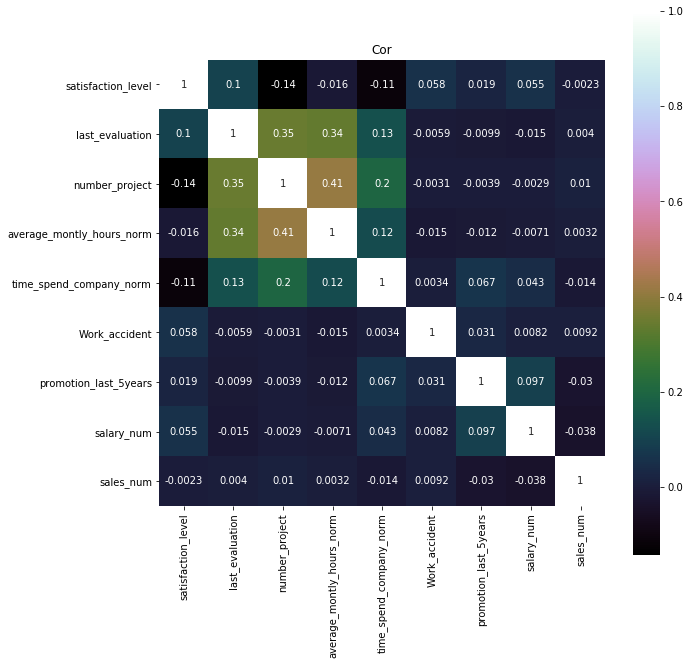

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
cor = pandas.DataFrame(trainingData).corr()
plt.figure(figsize=(10,10))
sns.heatmap(cor, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Cor')
plt.show()

Any correlation means that the dataset can be reducted in some way

In [76]:
trainingData = PCA(n_components=6).fit_transform(trainingData)
testData = PCA(n_components=6).fit_transform(testData)

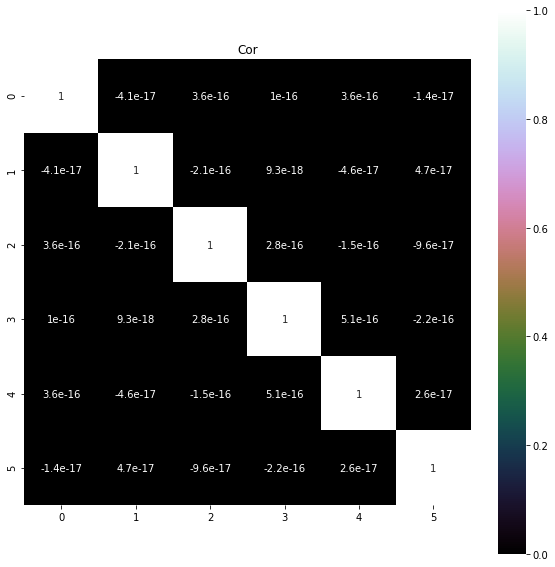

In [77]:
cor = pandas.DataFrame(trainingData).corr()
plt.figure(figsize=(10,10))
sns.heatmap(cor, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Cor')
plt.show()

Much better, this dataset near its smallest possible reduction. Ho

## Create the model 100x100x2

In [78]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical
from keras import regularizers
from keras.optimizers import SGD

In [79]:
reg = 0.0003

nnModel = Sequential()
nnModel.add(Dense(100, input_shape=(6,), kernel_regularizer=regularizers.l2(reg)))
nnModel.add(Activation("relu"))
nnModel.add(Dense(100, kernel_regularizer=regularizers.l2(reg)))
nnModel.add(Activation("relu"))
nnModel.add(Dense(2, kernel_regularizer=regularizers.l2(reg)))
nnModel.add(Activation("softmax"))
nnModel.summary()
sgd = SGD(lr=0.1, momentum=0.0, decay=0.00001, nesterov=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 100)               700       
_________________________________________________________________
activation_42 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_43 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 2)                 202       
_________________________________________________________________
activation_44 (Activation)   (None, 2)                 0         
Total params: 11,002
Trainable params: 11,002
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [80]:
import time
import sklearn.metrics
import numpy as np

start = time.time()
nnModel.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['categorical_accuracy'])
nnModel.fit(np.array(trainingData), to_categorical(trainingLabels), batch_size=32,epochs=20, shuffle=True)


Epoch 1/20
12000/12000 [==============================] - 0s - loss: 0.4005 - categorical_accuracy: 0.8488     
Epoch 2/20
12000/12000 [==============================] - 0s - loss: 0.3104 - categorical_accuracy: 0.8892     
Epoch 3/20
12000/12000 [==============================] - 0s - loss: 0.2960 - categorical_accuracy: 0.8942     
Epoch 4/20
12000/12000 [==============================] - 0s - loss: 0.2879 - categorical_accuracy: 0.8997     
Epoch 5/20
12000/12000 [==============================] - 0s - loss: 0.2836 - categorical_accuracy: 0.9030     
Epoch 6/20
12000/12000 [==============================] - 0s - loss: 0.2808 - categorical_accuracy: 0.9048     
Epoch 7/20
12000/12000 [==============================] - 0s - loss: 0.2766 - categorical_accuracy: 0.9061     
Epoch 8/20
12000/12000 [==============================] - 0s - loss: 0.2748 - categorical_accuracy: 0.9056     
Epoch 9/20
12000/12000 [==============================] - 0s - loss: 0.2722 - categorical_accuracy: 0.90

## Predict using the model. Best result F-score ~0.8

In [81]:
pred = nnModel.predict_classes(np.array(testData))
end = time.time()
print(end - start)
f1 = sklearn.metrics.f1_score(testLabels, pred)
print ('F1 Score:', f1)

  32/2999 [..............................] - ETA: 6s8.25850534439087
F1 Score: 0.800586510264
